In [11]:
# -*- coding: utf-8 -*-
# This notebook attempts to rigorously test the deployed model
# It does so my performing these test:
#   Overall accuracy
#   Accuracy per species
#   F1 score
#   Confusion matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import os
import pandas as pd
import cv2 as cv
from PIL import Image
from load_data import ForamDataSet
import matplotlib.pyplot as plt
from azureml.core.authentication import ServicePrincipalAuthentication
from azureml.core import Workspace
from azureml.core.model import Model


In [4]:
train_on_gpu = False
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # val does not use augmentation
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # test does not use augmentation
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './training-images'
master_csv = './data-csv/all.csv'
train_file = './data-csv/combined1_and_2.csv'
val_file = './data-csv/file3.csv'
test_file = './data-csv/file0.csv'
image_datasets = {}
image_datasets['train'] = ForamDataSet(csv_file=train_file,
                                       root_dir=data_dir,
                                       master_file='./data-csv/file0.csv',
                                       transform=data_transforms['train'])
image_datasets['val'] = ForamDataSet(csv_file=val_file,
                                     root_dir=data_dir,
                                     master_file='./data-csv/file0.csv',
                                     transform=data_transforms['val'])
image_datasets['test'] = ForamDataSet(csv_file=test_file,
                                      root_dir=data_dir,
                                      master_file='./data-csv/file0.csv',
                                      transform=data_transforms['test'])                                     
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
classes = image_datasets['train'].labels

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
def visualize_frequency(path):
    df = pd.read_csv(path)
    df = df.groupby('species').count()
    arr = [tuple((x)) for x in df.to_records()]
    arr = sorted(arr, key=lambda x:x[1], reverse=True)
    species = [str(i[0]) for i in arr]
    frequency = [int(i[1]) for i in arr]
    
    y_pos = np.arange(len(species))
    plt.bar(y_pos, frequency, align='center', alpha=0.5)
    plt.xticks(y_pos, species)
    plt.xticks(rotation=80)
    plt.ylabel('Frequency')
    plt.title('Species')

    plt.show()

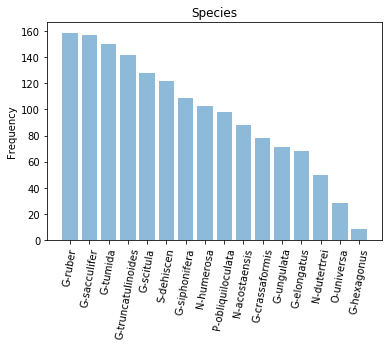

In [4]:
visualize_frequency(path='./data-csv/master.csv')

In [21]:
master_csv = pd.read_csv('./data-csv/master.csv').groupby('species').count().sort_values(by='location', ascending=False)
master_csv.columns = ['total']
print(master_csv)

                    total
species                  
G-ruber               159
G-sacculifer          157
G-tumida              150
G-truncatulinoides    142
G-scitula             128
S-dehiscen            122
G-siphonifera         109
N-humerosa            103
P-obliquiloculata      98
N-acostaensis          88
G-crassaformis         78
G-ungulata             71
G-elongatus            68
N-dutertrei            50
O-universa             28
G-hexagonus             8


In [5]:
def visualize_categories():
    train_csv = pd.read_csv('./data-csv/combined1_and_0.csv').groupby('species').count()
    val_csv = pd.read_csv('./data-csv/file3.csv').groupby('species').count()
    test_csv = pd.read_csv('./data-csv/file2.csv').groupby('species').count()
    merged_csv = pd.merge(pd.merge(train_csv, val_csv, on='species'), test_csv, on='species')
    merged_csv.columns = ['n_train', 'n_val', 'n_test']
    print(merged_csv.sort_values(by=['n_train'], ascending=False))

In [6]:
visualize_categories()

                    n_train  n_val  n_test
species                                   
G-ruber                  78     42      39
G-sacculifer             78     40      39
G-tumida                 74     39      37
G-truncatulinoides       70     37      35
G-scitula                64     32      32
S-dehiscen               60     32      30
G-siphonifera            54     28      27
N-humerosa               50     28      25
P-obliquiloculata        48     26      24
N-acostaensis            44     22      22
G-crassaformis           38     21      19
G-elongatus              34     17      17
G-ungulata               34     20      17
N-dutertrei              24     14      12
O-universa               14      7       7
G-hexagonus               4      2       2


In [7]:
# Verifies that there is no cross contamination between the files
# i.e a species does not show up twice
train_csv = pd.read_csv(train_file)['location'].values.tolist()
val_csv = pd.read_csv(val_file)['location'].values.tolist()
test_csv = pd.read_csv(test_file)['location'].values.tolist()
for item in train_csv:
    if item in val_csv:
        print(item)
    if item in test_csv:
        print(item)

In [12]:
def run():
    svc_pr = ServicePrincipalAuthentication(
        tenant_id="1faf88fe-a998-4c5b-93c9-210a11d9a5c2",
        service_principal_id="3683e499-d9d1-4b25-9e51-fc0c056415da",
        service_principal_password="R5q6DTJsLHmxPTYcegeXMQ/2I9pABbkRu9ru7h1Srtc=")
    # retrieve the path to the model file using the model name
    ws = Workspace.get(name='foram-workspace',
                       subscription_id='d90d34f0-1175-4d80-a89e-b74e16c0e31b',
                       auth=svc_pr)
    model_path = Model.get_model_path('resnet_cv', _workspace=ws)
    model = load_checkpoint(model_path)
    return model


def load_checkpoint(path):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 16)
    model.load_state_dict(torch.load(path, map_location='cpu'))
    model.idx_to_class = {0: 'G-crassaformis', 1: 'G-elongatus', 2: 'G-hexagonus', 3: 'G-ruber', 4: 'G-sacculifer', 5: 'G-scitula', 6: 'G-siphonifera', 7: 'G-truncatulinoides', 8: 'G-tumida', 9: 'G-ungulata', 10: 'N-acostaensis', 11: 'N-dutertrei', 12: 'N-humerosa', 13: 'O-universa', 14: 'P-obliquiloculata', 15: 'S-dehiscen'}
    return model

In [13]:
# Loads the model currently in use in Azure
model = run()

Text(0.5, 1.0, 'Validation Loss')

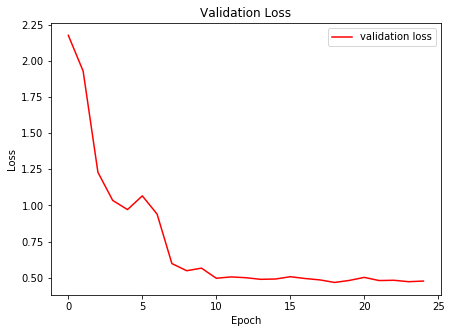

In [4]:
history = pd.read_csv('./model1/resnet1.csv')
val = history[history.phase=='val']
train = history[history.phase=='train']
val.reset_index(drop=True,inplace=True)
train.reset_index(drop=True,inplace=True)

plt.figure(figsize=(7, 5))
plt.plot(val['epoch_loss'], 'r', label='validation loss')
# plt.plot(train['epoch_loss'], 'g', label='training loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')

# plt.figure(figsize=(7, 5))
# plt.plot(val['epoch_acc'], 'r', label='validation accuracy')
# plt.plot(train['epoch_acc'], 'g', label='training accuracy')
# plt.legend(loc='upper right')
# plt.xlabel('Epoch')
# plt.ylabel('accuracy')
# plt.title('Training and Validation accuracy')

    Unnamed: 0  learning_rate  overall_accuracy
0            0         0.0001         69.791667
1            1         0.0002         79.166667
2            2         0.0003         82.552083
3            3         0.0004         81.250000
4            4         0.0005         88.541667
5            5         0.0006         88.281250
6            6         0.0007         86.458333
7            7         0.0008         86.458333
8            8         0.0009         90.364583
9            9         0.0010         87.500000
10          10         0.0012         89.322917
11          11         0.0014         84.895833
12          12         0.0016         85.156250
13          13         0.0018         82.812500
14          14         0.0020         84.114583
15          15         0.0022         82.812500
16          16         0.0024         85.156250
17          17         0.0026         82.291667
18          18         0.0028         81.510417


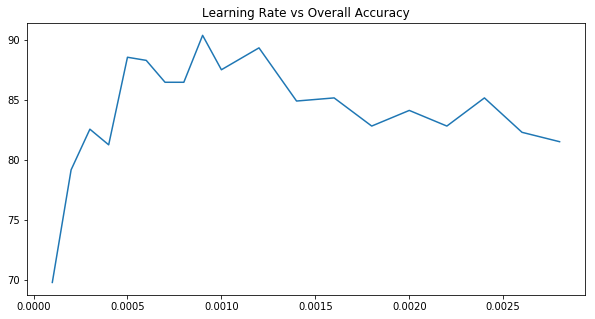

In [7]:
record = pd.read_csv('./explore/record.csv')
record = record[0:19]
plt.figure(figsize=(10, 5))
plt.plot(record['learning_rate'], record['overall_accuracy'])
plt.title('Learning Rate vs Overall Accuracy')
print(record)

In [40]:
def accuracy(output, target, topk=(1, )):
    """
    Compute the topk accuracy(s)
    target: the correct labelled answer
    """
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()
        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [41]:
def evaluate_for_categories(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, 16), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    for i in topk:
        results = pd.DataFrame(acc_results, columns=['top{i}'.format(i=i) for i in topk])
        results['class'] = classes
        results['loss'] = losses
        results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})
criterion = nn.CrossEntropyLoss()

In [42]:
results = evaluate_for_categories(model, dataloaders['test'], criterion)
test_csv = pd.read_csv('./data-csv/file2.csv').groupby('species').count()
test_csv = test_csv.reset_index()
test_csv.columns = ['class','total']
test_csv.rename({'species':'class'}, inplace=True)
results = pd.merge(results, test_csv, on='class')
print(results)

                 class        top1        top5      loss  total
0       G-crassaformis   68.421053  100.000000  0.915013     19
1          G-elongatus   70.588235   94.117647  1.382466     17
2          G-hexagonus   50.000000  100.000000  1.415903      2
3              G-ruber   89.743590  100.000000  0.280626     39
4         G-sacculifer   79.487179  100.000000  0.576091     39
5            G-scitula   84.375000   96.875000  0.783826     32
6        G-siphonifera   85.185185  100.000000  0.447159     27
7   G-truncatulinoides   94.285714  100.000000  0.282429     35
8             G-tumida   91.891892   97.297297  0.444041     37
9           G-ungulata  100.000000  100.000000  0.019817     17
10       N-acostaensis   90.909091  100.000000  0.319382     22
11         N-dutertrei   83.333333  100.000000  0.701763     12
12          N-humerosa   80.000000  100.000000  0.475119     25
13          O-universa   71.428571  100.000000  0.867334      7
14   P-obliquiloculata   83.333333  100.

In [25]:
def overall_accuracy(model, test_loader):
    model.eval()
    with torch.no_grad():
        counter = 0
        result = 0
        # Testing loop
        for data, targets in test_loader:
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')
            # Raw model output
            out = model(data)
            result += accuracy(model(data), targets)[0]
            counter += 1
    return result/counter

In [49]:
print(overall_accuracy(model, dataloaders['test']))

86.45833333333333


In [ ]:
def F1(model, test_loader):
    '''
    class_info = {class_index: [true_postiive,
                                false_positive,
                                total_per_species,
                                precision,
                                recall,
                                F-score]}
    '''
    model.eval()
    class_info = {}
    for i in range(len(image_datasets['train'].labels)):
        class_info[i] = [0,0,0]
    with torch.no_grad():
        for data, targets in test_loader:
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')
            out = model(data)
            _, pred = out.topk(k=1, dim=1, largest=True, sorted=True)
            pred = torch.squeeze(pred, 1)
            for i in range(len(targets)):
                if pred[i] == targets[i]: # prediction correct, add to true positive
                    temp = class_info[int(pred[i])]
                    temp[0] = temp[0] + 1
                    class_info[int(pred[i])] = temp
                else: # prediction wrong, add to false positive
                    temp = class_info[int(pred[i])]
                    temp[1] = temp[1] + 1
                    class_info[int(pred[i])] = temp
    test_csv = pd.read_csv('../test.csv').groupby('species').count()
    species = image_datasets['train'].labels
    for i in range(test_csv.shape[0]):
        row = test_csv.iloc[i]
        arr = class_info[species.index(row.name)]
        arr[2] = int(row.location)
        arr.append(arr[0]/(arr[0]+arr[1]))
        arr.append(arr[0]/arr[2])
        arr.append((2*arr[3]*arr[4])/(arr[3]+arr[4]))
        class_info[species.index(row.name)] = arr
    total_true_positives = 0
    total_false_postives = 0
    total = 0
    for key,values in class_info.items():
        total_true_positives += values[0]
        total_false_postives += values[1]
        total += values[2]
    micro_avg_prec = total_true_positives/(total_true_positives+total_false_postives)
    micro_avg_rec = total_true_positives/total
    micro_f1 = (2*micro_avg_prec*micro_avg_rec)/(micro_avg_prec+micro_avg_rec)
    df = pd.DataFrame.from_dict(class_info, orient='index',
                        columns=['true_positive','false_positive','total_per_species','precision','recall','F-score'])
    return micro_f1, df

In [ ]:
# In simple terms, high precision means that an algorithm returned substantially 
# more relevant results than irrelevant ones, while high recall means that an 
# algorithm returned most of the relevant results. -wiki
ans = F1(model, dataloaders['test'])
print(ans[1])
print(ans[0])

In [51]:
def construct_confusion_matrix(model):
    matrix = [[0 for i in range(len(classes))] for i in range(len(classes))]
    model.eval()
    with torch.no_grad():
        for data, targets in dataloaders['test']:
            out = model(data).numpy()
            for x, i in enumerate(out):
                matrix[targets.numpy()[x]][np.argmax(i)] += 1
    return matrix
matrix = construct_confusion_matrix(model)

In [52]:
for i in matrix:
    print(i)
confusion_matrix = pd.DataFrame(matrix, index=classes, columns=classes)
print(confusion_matrix)
'''
What this means is that for the 16 G-crassaformis, 13 were correctly predicted
The diagonal shows all the correct predictions
'''

[13, 0, 0, 0, 0, 4, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 13, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 3, 0, 33, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 2, 36, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 28, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 30, 1, 0, 0, 0, 2, 0, 1, 0]
[2, 0, 0, 0, 1, 0, 0, 0, 30, 0, 0, 0, 0, 0, 0, 4]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 15, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 20, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 2, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 20, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 20, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30]
                    G-crassaformis  G-elongatus  G-hexagonus  G-ruber  \
G-crassaformis                  13            0            0        0   
G-elongatus                      0           13          